# Kaggle Competition
## [Zillow Prize: Zillow’s Home Value Prediction (Zestimate)](https://www.kaggle.com/c/zillow-prize-1)

- The goal of this project is to develop an algorithm that makes predictions about the future sale prices of homes. 
- Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. 
- The log error is defined as logerror=log(Zestimate)−log(SalePrice) and it is recorded in the transactions training data.

### Install

This project requires **Python 2.7** and the following Python libraries installed:

- [NumPy](http://www.numpy.org/)
- [Pandas](http://pandas.pydata.org)
- [matplotlib](http://matplotlib.org/)
- [seaborn](https://seaborn.pydata.org/)

You will also need to have software installed to run and execute an [iPython Notebook](http://ipython.org/notebook.html)

### Code

Data visualization is provided in the `Zillow.ipynb` notebook file.

In [1]:
# Load module
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
% matplotlib inline

# Loading data

In [70]:
train_2016 = pd.read_csv('input/train_2016_v2.csv', index_col='transactiondate', parse_dates = ['transactiondate'])
print(train_2016.info())
print(train_2016.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90275 entries, 2016-01-01 to 2016-12-30
Data columns (total 2 columns):
parcelid    90275 non-null int64
logerror    90275 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.1 MB
None
                 parcelid  logerror
transactiondate                    
2016-01-01       11016594    0.0276
2016-01-01       14366692   -0.1684
2016-01-01       12098116   -0.0040
2016-01-02       12643413    0.0218
2016-01-02       14432541   -0.0050


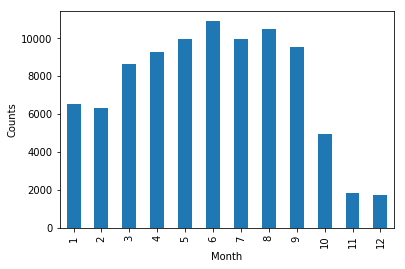

In [3]:
# Distribution of data throughout year
train_2016.month = train_2016.index.month
train_2016.month.value_counts().sort_index().plot.bar()
plt.xlabel('Month')
plt.ylabel('Counts')
plt.show()

In [10]:
train_2016.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

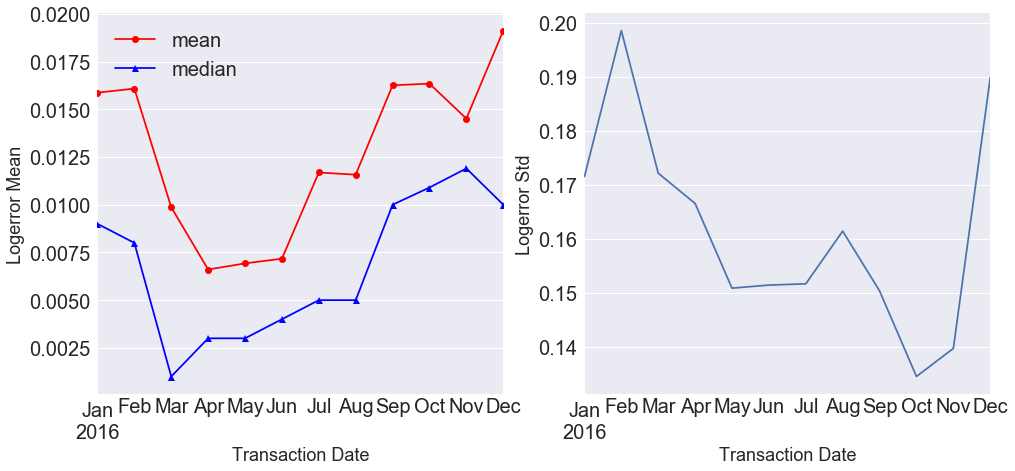

In [79]:
# The mean 
label_fs = 18
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
train_2016.logerror.resample('M').mean().plot(marker='o', color='r', label='mean')
train_2016.logerror.resample('M').median().plot(marker='^', color='b', label = 'median')
plt.legend()
plt.xlabel('Transaction Date', fontsize=label_fs)
plt.ylabel('Logerror Mean', fontsize=label_fs)
plt.subplot(1, 2, 2)
train_2016.logerror.resample('M').std().plot()
plt.xlabel('Transaction Date', fontsize=label_fs)
plt.ylabel('Logerror Std', fontsize=label_fs)
plt.show()

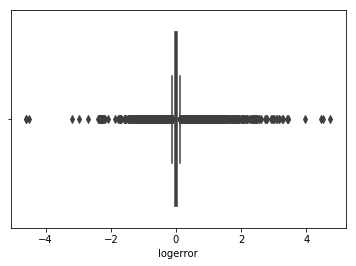

In [11]:
sns.boxplot(train_2016.logerror)
plt.show()

Upper boundary (0.99): 0.463882
Lower boundary (0.01): -0.342500


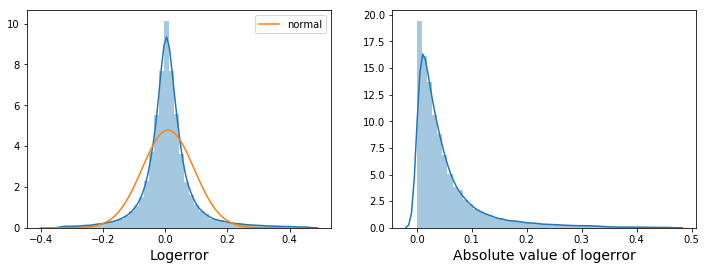

In [22]:
# truncate the data and keep data between 1% and 99%
import matplotlib.mlab as mlab
ulimit = np.percentile(train_2016.logerror.values, 99)
llimit = np.percentile(train_2016.logerror.values, 1)
print('Upper boundary (0.99): %lf' % ulimit)
print('Lower boundary (0.01): %lf' % llimit)
truncated_df = train_2016.loc[(train_2016.logerror<ulimit) & (train_2016.logerror>llimit), 'logerror']
# Plot distribution
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.distplot(truncated_df)
x = np.linspace(-0.4, 0.4, 100)
plt.plot(x, mlab.normpdf(x, truncated_df.mean(), truncated_df.std()), label='normal')
plt.legend()
plt.xlabel('Logerror', fontsize = label_fs)
plt.subplot(1, 2, 2)
sns.distplot(np.abs(truncated_df))
plt.xlabel('Absolute value of logerror', fontsize = label_fs)
plt.show()

### The analysis of logerror: 
According to the definition of logerror = log(Zestimate) - log(SalePrice), a positive value of logerror indicates Zestimate overestimate the data and a negative value indicates the opposite. The absolute value of the logerror implies the error size of Zestimate.
- The house market is warmer is summer season. The data in fourth quarter is kept for test purpose.
- On average, Zestimate model overestimates the sale price.
- Despite the large standard deviation of data, Zestimate model is more likely to overestimate the sale price in winter time.
- There exist extreme outliers, where the ratio of Zestimate / Sale price could be as large as 50 or as small as 0.02.
- After keeping the logerror between 1% and 99%, we see a heavy tailed distribution compared to normal distribution with the same mean and standard deviation.

In [24]:
# Load property data and merge with transaction data.
train_2016.reset_index(inplace=True)
prop2016 = pd.read_csv('input/properties_2016.csv', low_memory=False)
df2016 = train_2016.merge(prop2016, on='parcelid', how='left')
del prop2016
del train_2016
print(df2016.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
transactiondate                 90275 non-null datetime64[ns]
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
airconditioningtypeid           28781 non-null float64
architecturalstyletypeid        261 non-null float64
basementsqft                    43 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
buildingclasstypeid             16 non-null float64
buildingqualitytypeid           57364 non-null float64
calculatedbathnbr               89093 non-null float64
decktypeid                      658 non-null float64
finishedfloor1squarefeet        6856 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
finishedsquarefeet12            85596 non-null float64
finishedsquarefeet13            33 non-null float64
finishedsquarefeet15

In [275]:
# Look at the example of outliers
df2016[abs(df2016.logerror)>4]

,transactiondate,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,cluster
6416,2016-01-29,12728547,-4.605,NaN,NaN,NaN,1.0,3.0,NaN,7.0,...,NaN,57838.0,289210.0,2015.0,231372.0,3821.81,NaN,NaN,6.037503e+13,121
7318,2016-02-03,11617445,4.737,1.0,NaN,NaN,3.0,2.0,NaN,NaN,...,NaN,713986.0,2289855.0,2015.0,1575869.0,28355.10,NaN,NaN,6.037266e+13,120
22475,2016-04-05,12668872,4.445,NaN,NaN,NaN,3.0,4.0,NaN,4.0,...,NaN,344385.0,1064036.0,2015.0,719651.0,12303.69,NaN,NaN,6.037651e+13,80
22476,2016-04-05,12668867,4.520,NaN,NaN,NaN,3.0,4.0,NaN,4.0,...,NaN,2256798.0,2488740.0,2015.0,231942.0,28388.46,NaN,NaN,6.037651e+13,80
69228,2016-08-24,17257462,-4.605,NaN,NaN,NaN,2.5,3.0,NaN,NaN,...,NaN,221718.0,367233.0,2015.0,145515.0,4274.12,NaN,NaN,6.111008e+13,35
88788,2016-12-05,11557016,-4.510,NaN,NaN,NaN,2.0,3.0,NaN,7.0,...,NaN,133772.0,668863.0,2015.0,535091.0,8238.68,NaN,NaN,6.037272e+13,81


In [ ]:
# Remove the outliers
new_df = df2016[(df2016.logerror<ulimit) & (df2016.logerror>llimit)]
del df2016

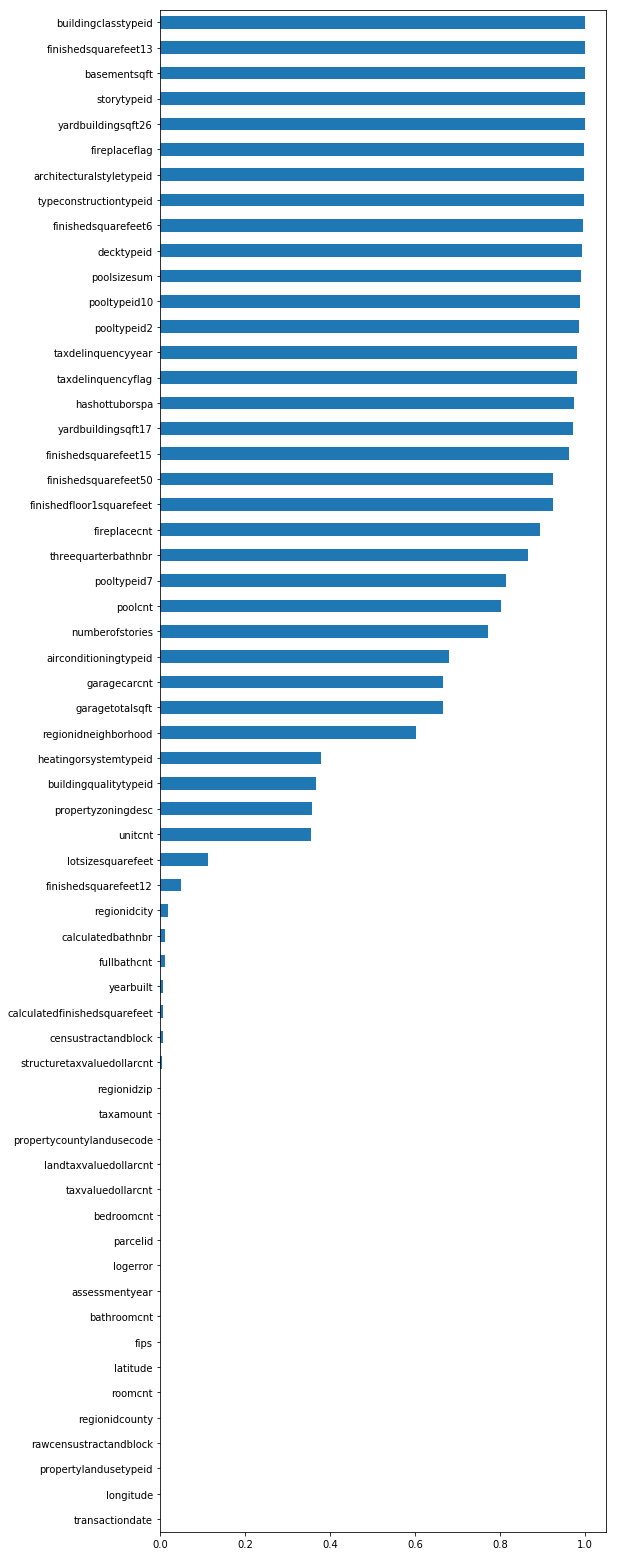

In [28]:
# Look at the missing values
nrow = new_df.shape[0]
nans = new_df.isnull().sum() / nrow
nans = nans.sort_values()
fig, ax = plt.subplots(figsize=(8,28))
rects = nans.plot.barh(ax= ax)
plt.show()

In [29]:
nans[nans>0.99]

decktypeid                  0.992686
finishedsquarefeet6         0.995591
typeconstructiontypeid      0.996643
architecturalstyletypeid    0.997072
fireplaceflag               0.997513
yardbuildingsqft26          0.998971
storytypeid                 0.999537
basementsqft                0.999537
finishedsquarefeet13        0.999661
buildingclasstypeid         0.999864
dtype: float64

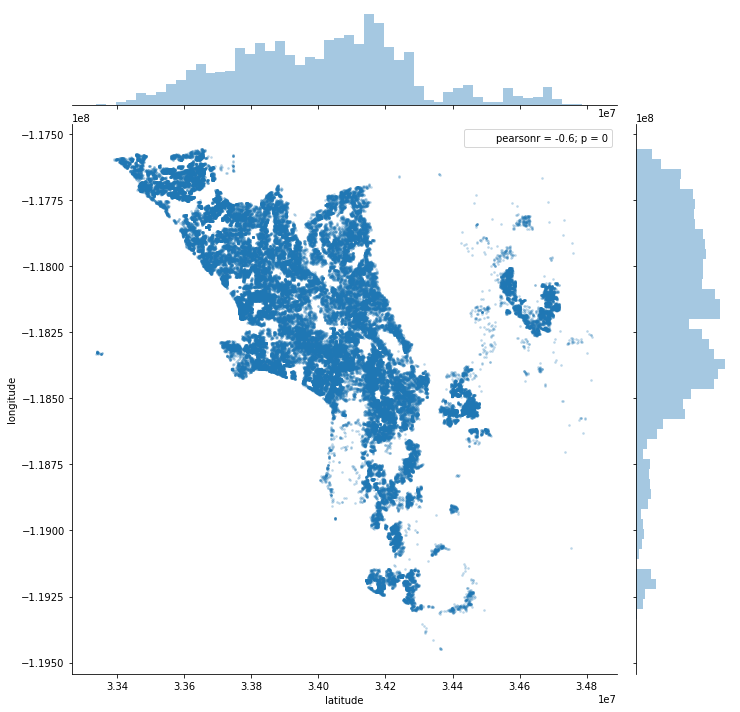

In [35]:
# Locational data
sns.jointplot(x='latitude', y='longitude', data=new_df, size=10, joint_kws={'s': 3, 'alpha':0.2})
plt.show()

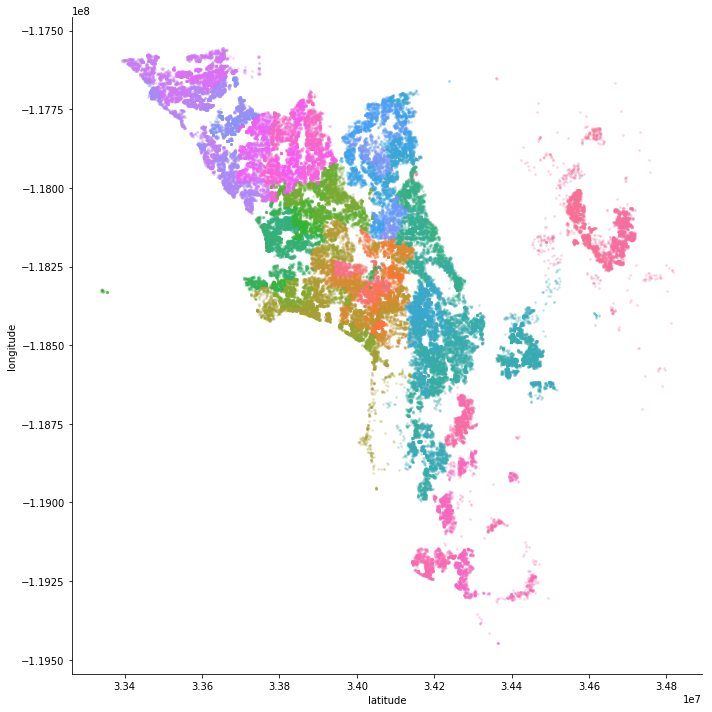

In [40]:
# The distribution of data among zipcodes
sns.lmplot(x='latitude', y='longitude', data=new_df, size=10, hue='regionidzip', 
           fit_reg=False, legend=False, scatter_kws={'s': 3, 'alpha':0.2})
plt.show()

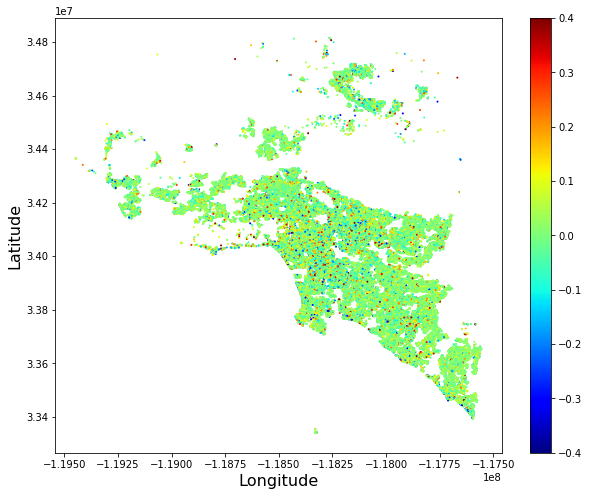

In [42]:
# The logerror on map
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('jet')
sc = plt.scatter(new_df.longitude, new_df.latitude, c=new_df.logerror, vmin = -0.4, vmax = 0.4, s=1, cmap=cm)
plt.colorbar(sc)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.show()

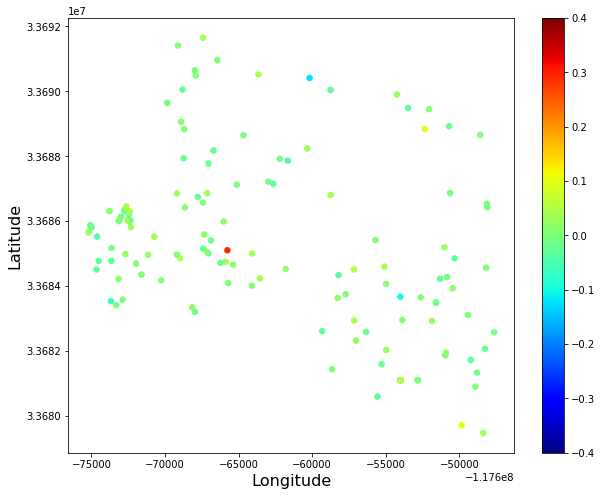

In [43]:
# Zoom in figure of logerror in one zip code area
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('jet')
zipid = 96946
sc = plt.scatter(new_df[new_df.regionidzip ==zipid].longitude, 
                 new_df[new_df.regionidzip ==zipid].latitude, 
                 c=new_df[new_df.regionidzip ==zipid].logerror, 
                 vmin = -0.4, vmax = 0.4, s=30, cmap=cm)
plt.colorbar(sc)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.show()

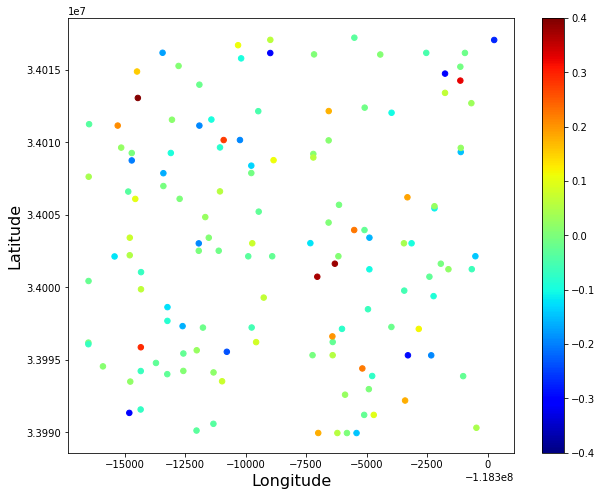

In [47]:
# Zoom in figure of logerror in the other zip code area
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('jet')
zipid = 96043
sc = plt.scatter(new_df[new_df.regionidzip ==zipid].longitude, 
                 new_df[new_df.regionidzip ==zipid].latitude, 
                 c=new_df[new_df.regionidzip ==zipid].logerror, 
                 vmin = -0.4, vmax = 0.4, s=30, cmap=cm)
plt.colorbar(sc)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.show()

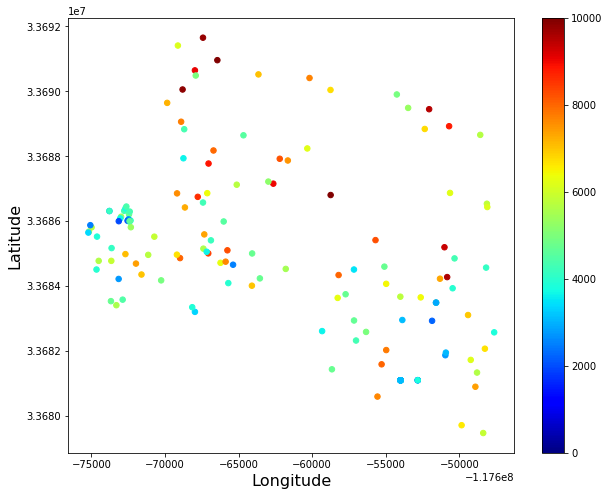

In [44]:
# Taxamount in 1st zip code area
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('jet')
zipid = 96946
sc = plt.scatter(new_df[new_df.regionidzip ==zipid].longitude, 
                 new_df[new_df.regionidzip ==zipid].latitude, 
                 c=new_df[new_df.regionidzip ==zipid].taxamount, 
                 s=30, vmin=0, vmax=10000, cmap=cm)
plt.colorbar(sc)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.show()

In [276]:
logerror_zip.loc[[96946, 96043], :]

,mean,median,std,count
regionidzip,,,,
96946,0.004528,0.0025,0.039855,152
96043,-0.006900,-0.0075,0.128773,136


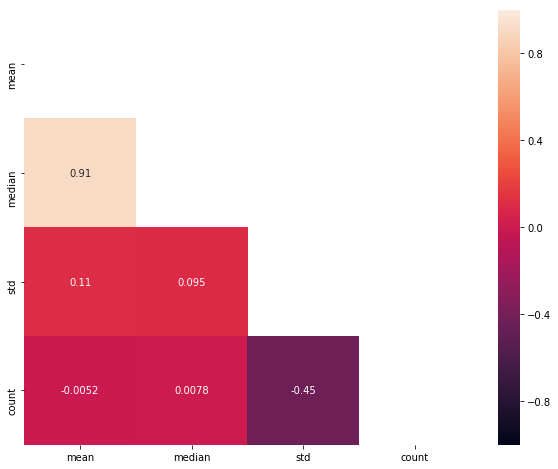

In [48]:
logerror_zip = new_df.groupby('regionidzip')['logerror'].agg(['mean', 'median', 'std', 'count'])
plt.figure(figsize=(10, 8))
mask = np.zeros((4,4))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(logerror_zip.corr(), annot=True, mask = mask, vmin=-1, vmax=1)
plt.show()

The performance of Zestimate depends on locations. The logerror heatmap of LA region shows a lot of noise. Take zipcode for instance, the performance of Zestimate varies from one district to another. 
The correlation coefficient between house number and logerror standard in regions is -0.45, implying that the district with less houses have a more spead distribution of Logerror.

(-0.5, 515.5, 515.5, -0.5)

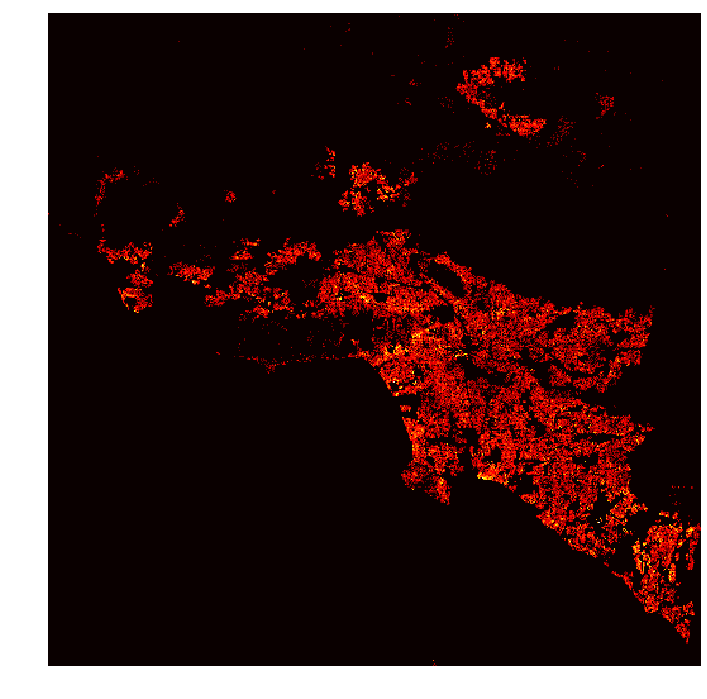

In [52]:
# Log(density) of houses

# Image size, location range for heatmap construction
im_size = (516, 516)
long_range = [-1.194479e+08, -1.175549e+08+1.194479e+08]
lat_range = [3.333930e+07, 3.481601e+07-3.333930e+07]
def get_coor(long, lat):
    # Get coordinate of point in heatmap from longitude and latitude.
    im_long = int((long - long_range[0]) / long_range[1] * im_size[0])
    im_lat = im_size[1]- int((lat - lat_range[0]) / lat_range[1] * im_size[1])
    return (im_long, im_lat)

location = new_df[['longitude', 'latitude']]
im_longitude =((location.longitude - long_range[0]) / long_range[1] * im_size[0]).astype(int)
im_latitude = im_size[1] - ((location.latitude - lat_range[0]) / lat_range[1] * im_size[1]).astype(int)
# Populate the regional trip density for heatmap
density = np.zeros(im_size)
for long, lat in zip(im_longitude, im_latitude):
    if long >= 0 and long < im_size[0] and lat >= 0 and lat < im_size[1]:
        density[lat, long] +=1
# Plot log trip density heatmap
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(np.log(density + 1), cmap='hot')
plt.axis('off')

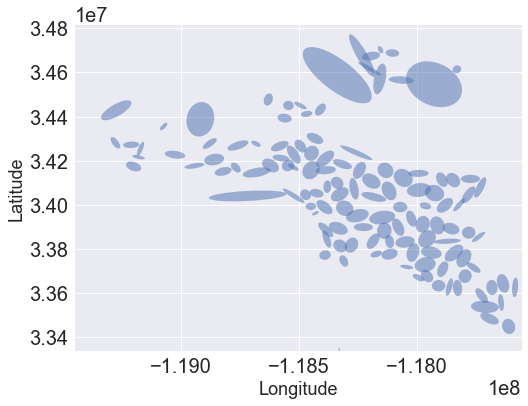

In [53]:
# Create new feature: cluster, to group houses.
from sklearn.mixture import GaussianMixture
# from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
from numpy import linalg
def create_cluster(df, n_cluster):
    """
    Create cluster by Guassian Mixture
    """
    gmm = GaussianMixture(n_components=n_cluster, covariance_type='full', random_state=1)
    # gmm = KMeans(n_clusters = n_cluster)
    gmm.fit(df[['longitude', 'latitude']])
    df['cluster'] = gmm.predict(df[['longitude', 'latitude']])
    means, covars = gmm.means_, gmm.covariances_
    fig, ax = plt.subplots(figsize=(8, 6))
    for mean, covar in zip(means, covars):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = Ellipse(mean, v[0], v[1], 180. + angle)
        # ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_patch(ell)
    urcornerlat = 3.481601e+07
    urcornerlong = -1.175549e+08
    llcornerlat = 3.333930e+07
    llcornerlong = -1.194479e+08
    plt.axis([llcornerlong, urcornerlong, llcornerlat, urcornerlat])
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude', fontsize=18)
    plt.show()
        
create_cluster(new_df, 125)    

Since in tree based algorithm, continuous data are divided in rectangular manner. New feature named cluster might be created, giving more info to the model.

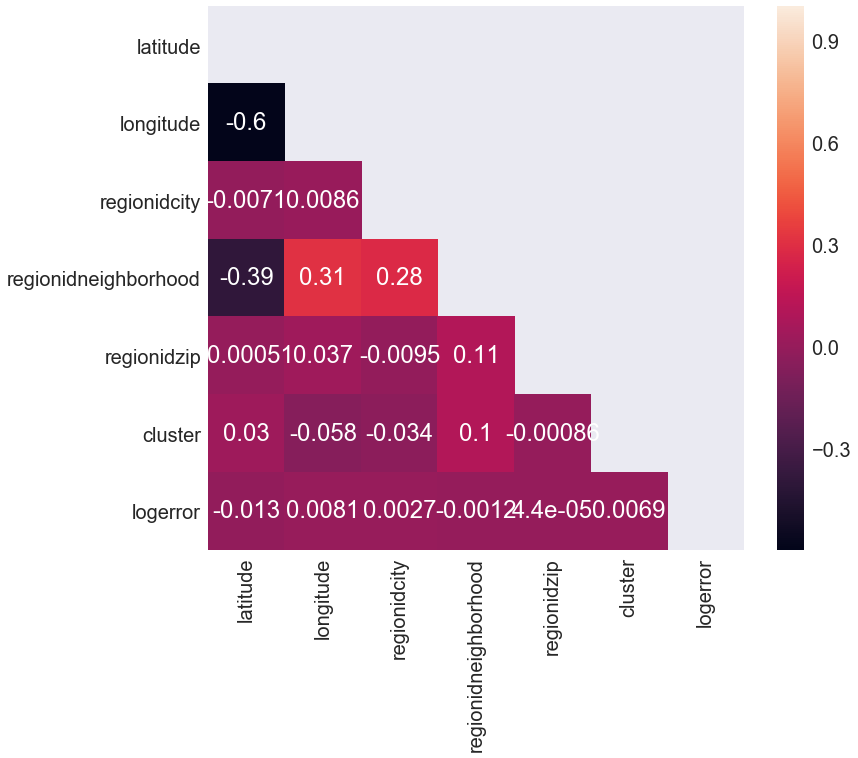

In [54]:
# Coefficient matrix of logerror and positional features.
pos = ['latitude', 'longitude', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'cluster', 'logerror']
mask = np.zeros((7,7))
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,10))
sns.heatmap(new_df[pos].corr(), mask = mask, vmax = 1, annot=True)
plt.show()

In [ ]:
room = ['logerror', 'bedroomcnt', 'bathroomcnt', 'roomcnt', 'unitcnt', 'fireplacecnt', 'garagecarcnt', 'poolcnt']
plt.figure(figsize=(12,10))
sns.heatmap(new_df[room].corr(), annot=True)
plt.show()

Logerror correlate positively with most of the cnt value.

In [ ]:
tax = ['logerror', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
plt.figure(figsize=(10,8))
sns.heatmap(df2016[tax].corr(), annot=True)
plt.show()

In [ ]:
area = ['logerror', 'basementsqft', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedfloor1squarefeet', 
        'poolsizesum']
plt.figure(figsize=(10,8))
sns.heatmap(df2016[area].corr(), annot=True)
plt.show()

Features 'finishedsquarefeet12' and 'calculatedfinishedsquarefeet' contain exactly the same information. Delete one of it.

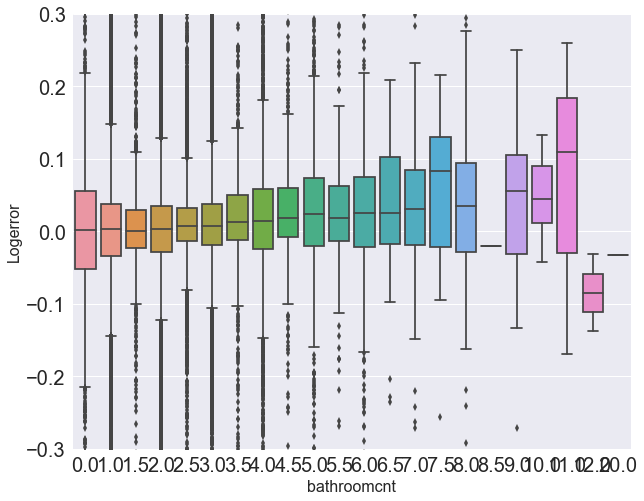

In [57]:
# The dependence of logerror on bathroom cnt.
plt.figure(figsize=(10,8))
sns.boxplot(x = 'bathroomcnt', y = 'logerror', data = new_df)
plt.xlabel('bathroomcnt', fontsize = 16)
plt.ylabel('Logerror', fontsize= 16)
plt.ylim([-0.3, 0.3])
plt.show()

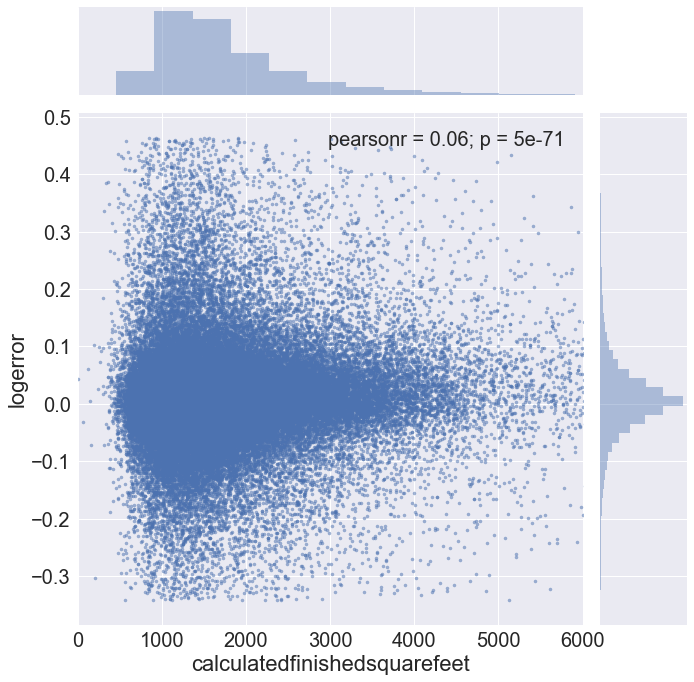

In [58]:
# The dependence of logerror on living room area
sns.set(font_scale=2)
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=new_df, 
              xlim = [0, 6000], size=10, joint_kws={'s': 10, 'alpha':0.5})
plt.show()

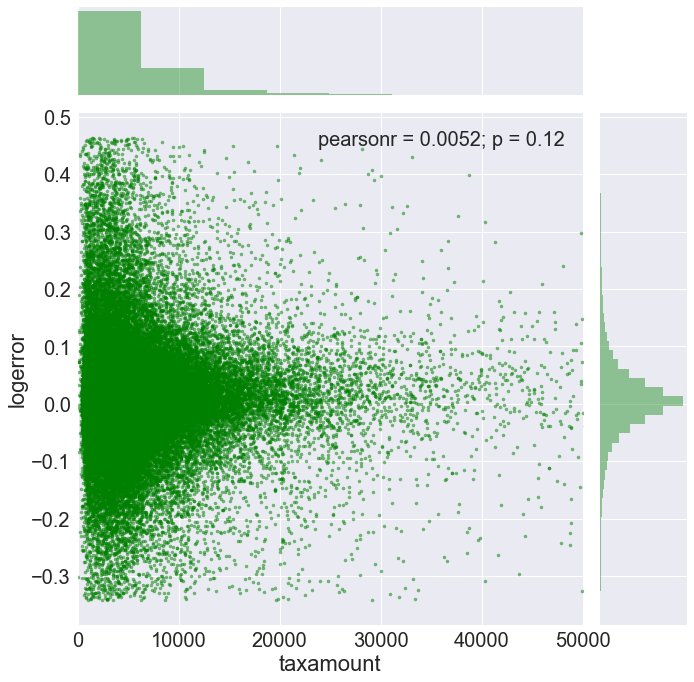

In [59]:
# The dependence of logerror on tax amount
sns.set(font_scale=2)
sns.jointplot(x='taxamount', y='logerror', data = new_df, xlim=[0, 50000], 
              size=10, color='g', joint_kws={'s': 10, 'alpha':0.5})
plt.show()

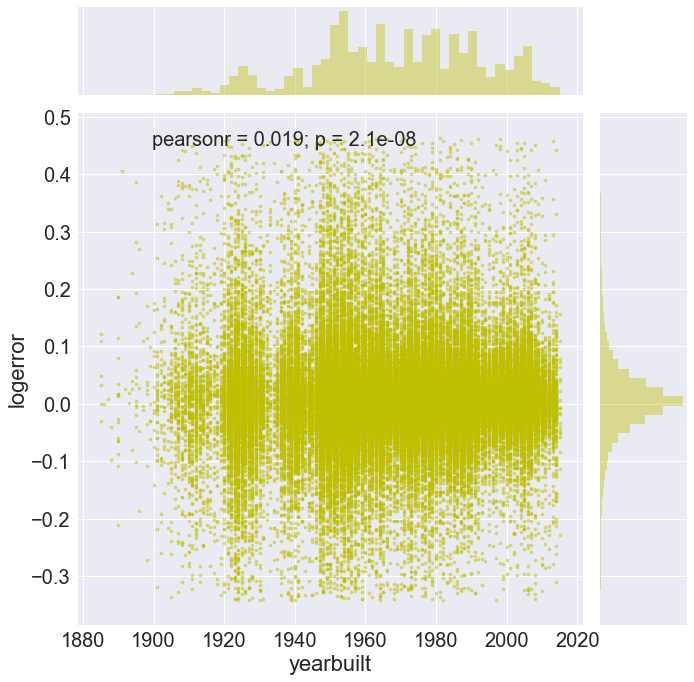

In [60]:
# The dependence of logerror on year
sns.set(font_scale=2)
sns.jointplot(x='yearbuilt', y='logerror', data=new_df, size=10, color='y', joint_kws={'s': 10, 'alpha':0.5})
plt.show()

In [61]:
# Create new feature: the tax per unit area
sns.set(font_scale=2)
new_df['tax_per_unit_area'] = new_df['taxamount'] / new_df['calculatedfinishedsquarefeet']

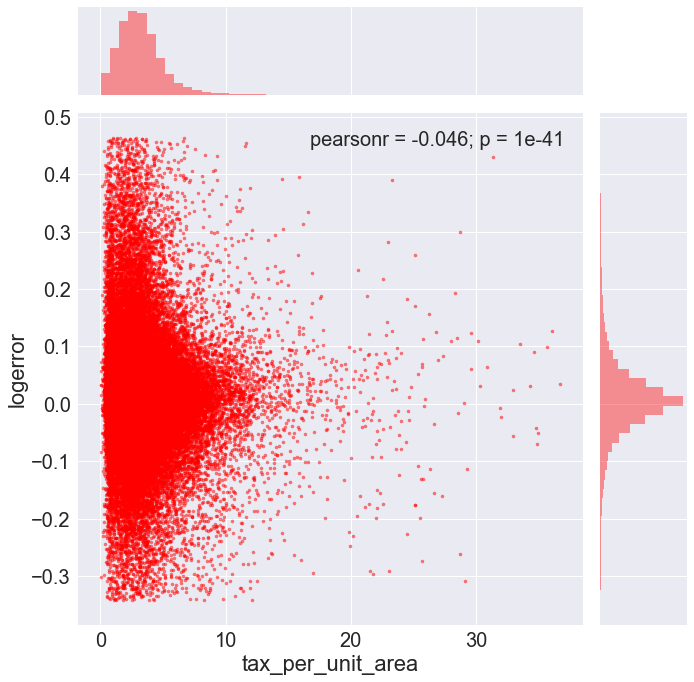

In [63]:
sns.set(font_scale=2)
sns.jointplot(x='tax_per_unit_area', y='logerror', data=new_df[new_df.tax_per_unit_area<40],
              size=10, color='r', joint_kws={'s': 10, 'alpha':0.5})
plt.show()

In [64]:
# Create new feature: the ratio of living room
new_df['living_to_total'] = new_df['calculatedfinishedsquarefeet']/ new_df['lotsizesquarefeet']

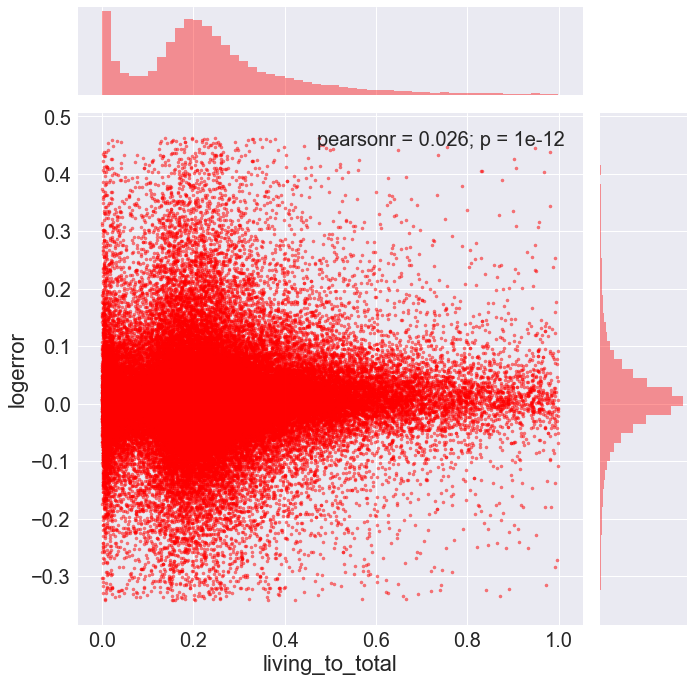

In [65]:
sns.set(font_scale=2)
sns.jointplot(x='living_to_total', y='logerror', data=new_df[new_df.living_to_total<1],
              size=10, color='r', joint_kws={'s': 10, 'alpha':0.5})
#plt.ylim([0, 50000])
plt.show()

In [66]:
# Create new feature: the average area per room
new_df['area_per_room'] = new_df['calculatedfinishedsquarefeet']/new_df['roomcnt']

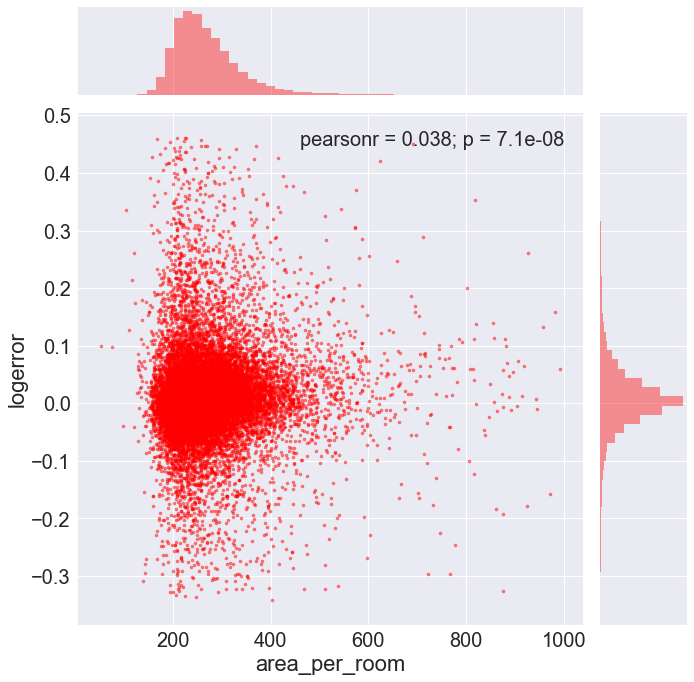

In [68]:
sns.set(font_scale=2)
sns.jointplot(x='area_per_room', y='logerror', data=new_df[(new_df.roomcnt>0) & (new_df.area_per_room<1000)],
              size=10, color='r', joint_kws={'s': 10, 'alpha':0.5})
#plt.ylim([0, 50000])
plt.show()

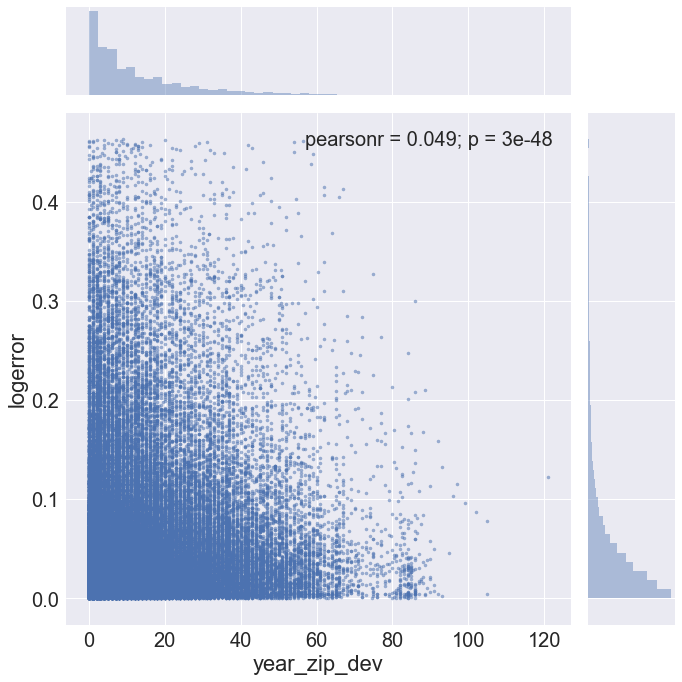

In [50]:
# The dependece of absolute logerror on the deviation of yearbuilt feature to the regional mean.
yearbuilt_zip = new_df.groupby('regionidzip')['yearbuilt'].agg(['median'])
yearbuilt_zip = yearbuilt_zip.to_dict()
def get_zip_year(x, yearbuilt_zip):
    if x in yearbuilt_zip:
        return yearbuilt_zip[x]
    else:
        return 1969
    
new_df['year_zip'] = new_df['regionidzip'].apply(lambda x: get_zip_year(x, yearbuilt_zip['median']))
new_df['year_zip_dev'] = new_df['yearbuilt'] - new_df['year_zip']

sns.set(font_scale=2)
sns.jointplot(x=abs(new_df['year_zip_dev']), y=abs(new_df['logerror']), size=10, joint_kws={'s': 10, 'alpha':0.5})
plt.show()